# Messing Around with GLMs

Revisiting what I learned about GLM (and ANOVA) by playing with some simulated data.
Also serves as some light coding practice (~~function mapping~~! list comprehensions! formatted strings!)

first we import some things:

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy.linalg import inv
import scipy.stats as stats

%matplotlib inline

Then here we have all the functions we use in the scripts below (I like to define them all in one place).

In [12]:
def gen_sample(size, mu, sigma=10):
    '''returns a sample drawn from a population with stdev sigma and mean mu'''
    x = sigma*np.random.randn(size)+mu
    return(x)


def gen_samples(groups, factors, sigma):
    '''returns multiple samples (from groups with different means) 
    not really necessary, could just do the list comprehension in the code below instead, but I'm lazy '''
    result = [gen_sample(x, y, sigma) for (x, y) in zip(groups, factors)]
    return(list(result))


def x_from_group(dim, n, group):
    '''convert group membership into dummy variables (0s and 1s) for use in design matrices'''
    x = np.zeros(dim)
    x[n] = 1
    x = np.tile(x, (group, 1))
    return(x)


def design_from_samples(groups, y):
    '''create a design matrix for all samples based on group membership'''
    X = [x_from_group(groups.size, n, group) for n, group in enumerate(groups)]
    X = np.vstack((X))
    X[:,0] = 1 #NOTE: the first group = the intercept, so we don't need to encode it! turns that row into all 1s
    return(X)


def est_beta(X,y):
    '''calculate predictor beta (with some beautiful linear algebra, imo)'''
    b = inv(X.T @ X) @ X.T @ y
    return b


def calc_sigma_hat(y, y_hat, p):
    '''does what it says on the tin. (p is the number of predictors estimated by our model)'''
    sigma_hat = np.sum((y-y_hat)**2)/(y.size-p)
    return sigma_hat


def calc_mse(y, y_hat):
    '''does what it says on the tin'''
    squared_error = (y-y_hat)**2
    mse = np.mean(squared_error)
    return mse


def calc_r2(y, y_hat):
    '''does what it says on the tin'''
    numerator = np.sum((y - y_hat) ** 2)  # remember, y_hat equals X * beta
    denominator = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - numerator / denominator
    return r_squared


def calc_f(r2, n, p):
    '''does what it says on the tin'''
    f = r2*(n-p)/((1-r2)*(p-1))
    return(f)

The function below comes from [the UvA's NI-edu course on GLM](https://github.com/Neuroimaging-UvA/NI-edu), cause I can't be bothered to write my own (and it's nicely generally applicable for both tests on single $\beta$s and contrasts $c$:

In [13]:
def design_variance(X, which_predictor=1):
    ''' Returns the design variance of a predictor (or contrast) in X.
    
    Parameters
    ----------
    X : numpy array
        Array of shape (N, P)
    which_predictor : int or list/array
        The index of the predictor you want the design var from.
        Note that 0 refers to the intercept!
        Alternatively, "which_predictor" can be a contrast-vector
        
    Returns
    -------
    des_var : float
        Design variance of the specified predictor/contrast from X.
    '''
    
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0
    
    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

OK, with all that out of the way, let's generate a test sample to make sure our code does what we think it does:

A sample of n = 20 observations from a population with mu = 5 and sigma = 1: [  9.20629644   3.92532908   5.67753592  -0.57763553   0.46042082
  -7.69268896  24.08675297   0.93910494   0.45374007   0.83956444
   5.71467225   8.49887637  27.06544212 -13.95822209   1.98873099
 -12.88209606   1.44239906  -0.5433852   13.89889057  -1.50169174]
the mean of our test sample is 3.3521018218682217


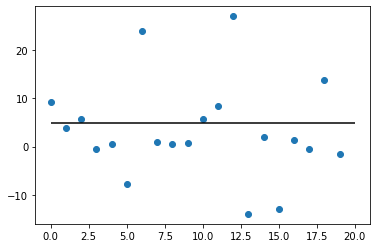

In [14]:
n = 20
mu = 5
sigma = 1
test_pop = gen_sample(n,mu)
test_string = f"A sample of n = {n} observations from a population with mu = {mu} and sigma = {sigma}: {test_pop}"
print(test_string)
print(f"the mean of our test sample is {test_pop.mean()}")
plt.scatter(range(n),test_pop)
plt.hlines(5,xmin=0,xmax=20)

That seems to work! Now how about some samples from different populations with a different $\mu$? Note that $\sigma$ is the same between groups! (*homoscedasticity*!)

In [15]:
groups = np.array([20, 20, 20, 20])
factors = np.array([1, 3, 5, 7])
sigma = 2
samples = gen_samples(groups, factors,sigma)
print(f"the means of the generated samples are {[sample.mean() for sample in samples]}")
sample_array = np.hstack((samples))

#let's stick the samples together as a series of observations
print(f"the overall mean of the sample is {sample_array.mean()}")

the means of the generated samples are [1.403815963832669, 3.473774091673021, 4.855772532082191, 6.479904364796404]
the overall mean of the sample is 4.053316738096072


The group means seem to match up with the factors ($\mu$) we defined. A GLM with group membership as predictors (encoded as dummy variables) should find these group means as beta values!

true population means are [1 3 5 7]

betas are [1.40381596 2.06995813 3.45195657 5.0760884 ]

standard error of the model is 4.302310141802823

design variances for the betas are [0.05 0.1  0.1  0.1 ]

t-values of the betas are [3.02673443 3.15580895 5.26277091 7.73888369]

the model's MSE is 4.087194634712683 and the model's r2 is 0.45930795399978763

the F statistic of our model is 21.520200985762948


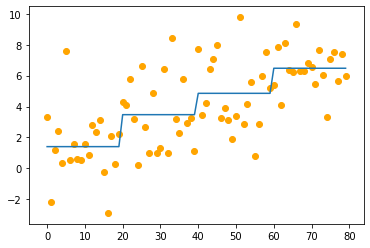

In [16]:
# now we build a group model (BASICALLY an ANOVA)
y = sample_array
X = design_from_samples(groups,y)
X_lin = np.zeros([y.size,2])
b = est_beta(X,y)
y_hat = X @ b
plt.plot(y_hat)

#(or a simple a + xb linear model!)
X_lin[:,0] = 1
X_lin[:,1] = np.arange(y.size)
b_lin = est_beta(X_lin, y)
y_hat_lin = X_lin @ b_lin
#plt.plot(y_hat_lin)


plt.scatter(range(y.size),y,color='orange')

#this is where we do the hypothesis tests on our group model
sigma_hat = calc_sigma_hat(y, y_hat, b.size)
des_var = np.array([design_variance(X, n) for n, _ in enumerate(b)])
mse = calc_mse(y, y_hat)
r2 = calc_r2(y, y_hat)
t = b/np.sqrt(sigma_hat*des_var)
glm_f = calc_f(r2, y.size, 4)
print(f"true population means are {factors}\n")
print(f"betas are {b}\n")
print(f"standard error of the model is {sigma_hat}\n")
print(f"design variances for the betas are {des_var}\n")
print(f"t-values of the betas are {t}\n")
print(f"the model's MSE is {mse} and the model's r2 is {r2}\n")
print(f"the F statistic of our model is {glm_f}")

#working with contrasts to compare betas/groups:
#c = np.array([0, 1, -1, 0])
#print(c.dot(b)/np.sqrt(sigma_hat*design_variance(X,c)))

Sure enough, the betas (plus the intercept) are exactly equivalent to each of the group means. Their t-values are all nice and big, and the F statistic confirms that we are at the very least right in designing our model with something other than a single mean as predictor.

As a fun aside - from the shape of the data, we can expect a simple linear model with an intercept and 1 predictor to also perform decently! (left as an exercise to the reader)

Since ANOVA is just a form of glm with dummy variables (which is exactly what we did here!), the F statistic of our group model and an ANOVA package should be exactly identical 
(allowing for floating point errors). Let's check whether that is indeed the case, as a sanity check (and because seeing is believing)

In [17]:


anova_f = stats.f_oneway(samples[0], samples[1], samples[2], samples[3])
print(f"the f statistic of our samples found by one-way anova is {anova_f.statistic}, \
which corresponds to a p-value of {anova_f.pvalue}")

if glm_f - anova_f.statistic < 0.0000001:
    print("the f statistic of our model and the f statistic found by scipy are identical!")
    
#this nicely shows that a glm f test tests THE SAME THING as the f test in a one-way anova: they're equivalent!
#

the f statistic of our samples found by one-way anova is 21.52020098576293, which corresponds to a p-value of 3.436853069748418e-10
the f statistic of our model and the f statistic found by scipy are identical!


It works!

In [18]:
#tbc